In [1]:
#importing the needed libraries
import numpy as np
import matplotlib.pyplot as plt

#to install celluloid do: pip install celluloid
from celluloid import Camera  


In [2]:
#Constants

#planet's mass
M_J = 1.899*10**30 #g

#planet's semi major axis
r_J = 1.496*10**15 #cm

#star's mass
M_star = 10**33 #g

#gravity constant
G = 6.67*10**(-8)  #cm^3g^−1s^−2

#planet's orbital period calculated using kepler's 3rd law
T = np.sqrt(((4*(np.pi**2)) / (G*(M_star + M_J)))*r_J**3)

#prints the orbital period in years
print("Orbital Period:", round(T / 3.154e+7,2) , "yrs.")

Orbital Period: 1410.07 yrs.


In [3]:
#Initial values for planet before integration scheme 

#initial x and y values
x0 = 0 #cm
y0 = r_J #cm
ri2 = x0**2 + y0**2 

#initial position vector
r0 = np.array([x0,y0]) #cm

#initial velocity vector
v0 = np.array([np.sqrt(((G*M_star)/(r_J))),0.]) #cm/s
#velocity components
dx0 = v0[0]
dy0 = v0[1]

#initial acceleration vector
a0 = np.array([(-G*M_star/(ri2))*(x0/(np.sqrt(ri2))),(-G*M_star/(ri2))*(y0/(np.sqrt(ri2)))]) #cm/s^2

#intial jolt vector
da0 = np.array([-G*M_star*((dx0/((ri2)**(3/2))) + 3*((np.dot(v0,r0)*x0)/((ri2)**(5/2)))),
                           -G*M_star*((dy0/((ri2)**(3/2))) + 3*((np.dot(v0,r0)*y0)/((ri2)**(5/2))))]) #cm/s^3

In [7]:
#Initial values for host star before integration scheme 

#initial position vector placing star at the origin
r1 = np.array([0.,0.]) #cm

#assuming velocity rounds to zero
v1 = np.array([0.,0.]) #cm/s
#velocity components
dx1 = v1[0]
dy1 = v1[1]

#inital acceleration vector
a1 = np.array([0,(G*M_J/(r_J**2))]) #cm/s^2

#initial jolt vector
da1 = np.array([-G*M_J*((dx1/((ri2)**(3/2))) + 3*((np.dot(v0,-r0)*x0)/((ri2)**(5/2)))),
                           -G*M_J*((dy1/((ri2)**(3/2))) + 3*((np.dot(v0,-r0)*-y0)/((ri2)**(5/2))))]) #cm/s^3

#Checking if forces are equal
print("Checking Forces are equal:")
print("F1 = ", '%.8g' % abs(a1[1]*M_star), "dyne")
print("F0 = ", '%.8g' % abs(a0[1]*M_J), "dyne")

Checking Forces are equal:
F1 =  5.6596244e+25 dyne
F0 =  5.6596244e+25 dyne


In [8]:
#Initial values for third body star before integration scheme 

#x and y coordinates 
x_star = 1.496e+16*1.11 #cm
y_star = -1.496e+16 #cm

#star's mass 
m_star = M_star

#initial position vector
r_star = np.array([x_star, y_star]) #cm

#initial velocity vector, assume constant velocity 
v_star = np.array([0, 100000]) #cm/s
#velocity components
dx_star = v_star[0]
dy_star = v_star[1]

#initial acceleration vector
a_star = np.array([0,0]) #cm/s^2

#initial jolt vector
da_star = np.array([0,0]) #cm/s^3

In [33]:
#Initial Energies

#kinetic energy of planet 
KEi_planet = (1/2)*M_J*(np.linalg.norm(v0)**2)

#kinetic energy of star 1:
KEi_star1 = (1/2)*M_star*(np.linalg.norm(v1)**2)

#kinetic energy of star 2: 
KEi_star2 = (1/2)*m_star*(np.linalg.norm(v_star)**2)

#potential energy between planet and star 1
Ui_planet = G*M_star*M_J / np.linalg.norm(r0)**2

#potential energy between planet and star 2
Ui_planet2 = G*m_star*M_J / ((np.linalg.norm(r_star - r0))**2)

#potential energy between star 1 and star 2
Ui_stars = G*M_star*m_star / (np.linalg.norm(r_star)**2)

#total intial energy for the sing planetary system without the third body 
Ei_total1 = KEi_planet + KEi_star1 + Ui_planet 

#total intial energy for three body system
Ei_total = KEi_planet + KEi_star1 + KEi_star2 + Ui_planet + Ui_planet2 + Ui_stars

In [10]:
#adds initial values to lists 

r_all = [r0,r1,r_star]
v_all = [v0,v1,v_star]
a_all = [a0,a1,a_star]
da_all = [da0,da1,da_star]
m_all = [M_J, M_star, m_star]


In [12]:
def Hermite(m_all, r_all, v_all, a_all, da_all, dt, tmax, N): 
    '''
    4th Order Hermite Integration Scheme: calculates the position, velocity, and acceleration of each
    body in an N body system at each timestep, dt in a total time, tmax when given mass values and inital values 
    for position, velocity, acceleration and jolt for each body at t = 0. 
    
    Parameters:
    ----------
    m_all:
    
    r_all:
    
    v_all:
    
    da_all:
    
    dt: 
    
    tmax:
    
    N:
    
    Returns:
    -------
    x_time:
    
    y_time:
    
    vx_time:
    
    vy_time:
    
    '''
    #sets count and initial time to be zero before loop 
    count = 0 
    ti = 0
    
    #accuracy parameter
    n = 0.01
    
    #empty lists for position and velocity values
    r_ti_all = []
    v_ti_all = []
    
    #empty lists for new acceleration and jolt values
    a_sums = [[]]*N
    da_sums = [[]]*N
    
    #empty lists for old acceleration and jolt values
    a_old = []
    da_old = []
    
    #empty lists for all position and velocity values
    x_time = np.empty((N,int(tmax/dt)))
    y_time = np.empty((N,int(tmax/dt)))
    vx_time = np.empty((N,int(tmax/dt)))
    vy_time = np.empty((N,int(tmax/dt)))
    
    #4th order hermite integration scheme loop
    while ti < tmax : 
        #adds timestep, dt to current time, ti each loop
        ti = ti + dt
        
        #reseting the following lists as zero each loop 
        
        #empty lists for position and velocity prediction values
        rip_all = []
        vip_all = []
        
        #empty lists for 2nd and 3rd derivative of acceleration values
        d2a0_all = []
        d3a0_all = []
        
        #empty lists for old acceleration and jolt values
        a_old = []
        da_old = []
        
        #loop that goes through each body in the N body system 
        for i in range(0,N):
            
            #sets values at current timestep for body i
            if count == 0: 
                ri = r_all[i]
                vi = v_all[i]
                ai = a_all[i]
                dai = da_all[i]
            
            else:
                ri = r_ti_all[i]
                vi = v_ti_all[i]
                ai = a_sums[i]
                dai = da_sums[i]
            
            #sets acceleration and jolt to be zero
            a = 0
            da = 0
            
            #calculates position and velocity prediction for body i
            rip = ri + vi*(dt) + 0.5*ai*(dt)**2 + (1/6)*dai*(dt)**3
            vip = vi + ai*(dt) + 0.5*dai*(dt)**2
            
            #adds position and velocity prediction to lists
            rip_all.append(rip)
            vip_all.append(vip)
            
            #loop that goes through each body in N body system 
            for j in range (0,N):
                
                #calculations below only run if body j is different then body i
                if i != j: 
                    
                    #sets values at current timestep for body j
                    if count == 0: 
                        rj = r_all[j]
                        vj = v_all[j]
                        aj = a_all[j]
                        daj = da_all[j]
                    
                    else: 
                        rj = r_ti_all[j]
                        vj = v_ti_all[j]
                        aj = a_sums[j]
                        daj = da_sums[j]   
                        
                    #calculates position and velocity predition for body j 
                    rjp = rj + vj*(dt) + 0.5*aj*(dt**2) + (1/6)*daj*(dt**3)
                    vjp = vj + aj*(dt) + 0.5*daj*(dt**2) 
                    
                    #calculates distance between the two bodies
                    rij = rjp - rip
                    
                    #calculates velocity of body i relative to j
                    vij = vjp - vip 
                    
                    #summation calculation of the acceleration of body i 
                    a = a + (G*m_all[j]*rij) / ((np.linalg.norm(rij)**2)**(3/2))
                    da = da + G*m_all[j]*((vij/((np.linalg.norm(rij))**2)**(3/2)) + 3*(np.dot(vij,rij)*rij)/
                                      ((np.linalg.norm(rij)**2)**(5/2)))
            
            #adds acceleration values from last time to a list
            if count > 0 :
                a_old.append(a_sums[i])
                da_old.append(da_sums[i])
            else: 
                a_old.append(a_all[i])
                da_old.append(da_all[i])
            
            #updates current acceleration and jolts to list 
            a_sums[i] = a
            da_sums[i] = da
        
        #clears past position and acceleration values
        r_ti_all = []
        v_ti_all = []
        
        for i in range(0,N):
            
            #calculates current acceleration derivatives for body i
            d2a0 = (-6*(a_old[i] - a_sums[i]) - dt*(4*da_old[i] + 2*da_sums[i])) / dt**2
            d3a0 = (12*(a_old[i] - a_sums[i]) + 6*dt*(da_old[i] + da_sums[i])) / dt**3
            
            #calculates position and velocity correction valeus
            r_ti = rip_all[i] + ((dt**4)/24)*d2a0 + ((dt**5)/120)*d3a0
            v_ti = vip_all[i] + ((dt**3)/6)*d2a0 + ((dt**4)/24)*d3a0
            
            #adds correction values to lists and arrays      
            r_ti_all.append(r_ti)
            v_ti_all.append(v_ti)
            
            x_time[i,count] = r_ti[0]
            y_time[i,count] = r_ti[1]
            
            vx_time[i,count] = v_ti[0]
            vy_time[i,count] = v_ti[1]
        
        #adds 1 to count total
        count = count + 1
        
    #returns all positions and velocities at each timestep
    return [x_time, y_time, vx_time, vy_time]


In [15]:
#good timestep based on planet's orbital period
dt = T/10000 

#uses 4th order hermite integration scheme to simulate a single planet system
sim_data = Hermite(m_all, r_all, v_all, a_all, da_all, dt, T, 2)

#uses 4th order hermite integration scheme to simulate the evolution of a
#single planet system that is subject to an external perturbation due to a passing star
sim_data2 = Hermite(m_all, r_all, v_all, a_all, da_all, dt, 8*T, 3)

In [41]:
#Final Energy calculation for the single planet system 

#planet - star 1 final distance
rf_planet_star1  = np.sqrt((sim_data[0][0,-1] - sim_data[0][1,-1])**2 + (sim_data[1][0,-1] - sim_data[1][1,-1])**2)

#planet final velocity squared
v2_planet = sim_data[2][0,-1]**2 + sim_data[3][0,-1]**2

#star 1 final velocity squared
v2_star1 = sim_data[2][1,-1]**2 + sim_data[3][1,-1]**2

#kinetic energy of planet 
KEf_planet = (1/2)*M_J*(v2_planet)

#kinetic energy of star 1:
KEf_star1 = (1/2)*M_star*(v2_star1)

#potential energy between planet and star 1
Uf_planet = G*M_star*M_J / ((rf_planet_star1)**2)

#total final energy 
Ef_total1 = KEf_planet + KEf_star1 + Uf_planet 

#prints initial and final energy 
print("Initial Energy:", Ei_total1, "ergs")
print("Final Energy:", Ef_total1, "ergs")

#they are conserved to a reasonable degree if their difference is within: 
e = 1e+37 #ergs

#checking if energy is conserved reasonably 
if Ef_total1  - Ei_total1 < e:
    print("Energy is conserved.")
else: 
    print("Energy is not conserved.")

Initial Energy: 4.233399064171128e+40 ergs
Final Energy: 4.233401612439033e+40 ergs
Energy is conserved.


In [42]:
#Final Energy calculation for the single planet system that is subject to an external perturbation 
#due to a passing star

#planet - star 1 final distance
rf_planet_star1  = np.sqrt((sim_data2[0][0,-1] - sim_data2[0][1,-1])**2 + (sim_data2[1][0,-1] - sim_data2[1][1,-1])**2)

#planet - star 2 final distance 
rf_planet_star2 = np.sqrt((sim_data2[0][0,-1] - sim_data2[0][2,-1])**2 + (sim_data2[1][0,-1] - sim_data2[1][2,-1])**2)

#star 1- star 2 final distance 
rf_star1_star2 = np.sqrt((sim_data2[0][1,-1] - sim_data2[0][2,-1])**2 + (sim_data2[1][1,-1] - sim_data2[1][2,-1])**2)

#planet final velocity squared
v2_planet = sim_data2[2][0,-1]**2 + sim_data2[3][0,-1]**2

#star 1 final velocity squared
v2_star1 = sim_data2[2][1,-1]**2 + sim_data2[3][1,-1]**2

#star 2 final velocity squared
v2_star2 = sim_data2[2][2,-1]**2 + sim_data2[3][2,-1]**2

#kinetic energy of planet 
KEf_planet = (1/2)*M_J*(v2_planet)

#kinetic energy of star 1:
KEf_star1 = (1/2)*M_star*(v2_star1)

#kinetic energy of star 2: 
KEf_star2 = (1/2)*m_star*(v2_star2)

#potential energy between planet and star 1
Uf_planet = G*M_star*M_J / ((rf_planet_star1)**2)

#potential energy between planet and star 2
Uf_planet2 = G*m_star*M_J / ((rf_planet_star2)**2)

#potential energy between star 1 and star 2
Uf_stars = G*M_star*m_star / ((rf_star1_star2)**2)

#total final energy 
Ef_total = KEf_planet + KEf_star1 + KEf_star2 + Uf_planet + Uf_planet2 + Uf_stars

#prints initial and final energy
print("Initial Energy:", Ei_total, "ergs")
print("Final Energy:", Ef_total, "ergs")

#they conserved to a reasonable degree is their difference is within: 
e = 1e+42 #ergs

#checking if energy is conserved reasonably 
if Ef_total  - Ei_total < e:
    print("Energy is conserved.")
else: 
    print("Energy is not conserved.")

Initial Energy: 5.042333990641711e+42 ergs
Final Energy: 5.902153122890578e+42 ergs
Energy is conserved.


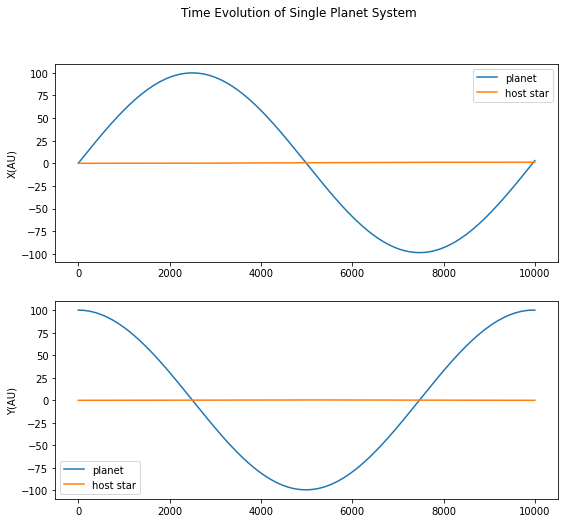

In [22]:
#conversion to AU
AU = 1.49598073e+13 #cm

#plotting the positions of a single planet system over time
fig, axs = plt.subplots(2)
fig.suptitle('Evolution of Single Planet System')
fig.set_figheight(8)
fig.set_figwidth(9)

axs[0].plot(sim_data[0][0,:]/AU, label = 'planet')
axs[0].plot(sim_data[0][1,:]/AU, label = 'host star')

axs[1].plot(sim_data[1][0,:]/AU, label = 'planet')
axs[1].plot(sim_data[1][1,:]/AU, label = 'host star')

axs[0].legend()
axs[0].set_ylabel("X(AU)")
axs[1].set_ylabel("Y(AU)")
axs[1].legend()

plt.savefig("SinglePlanetSystem.pdf")
plt.show()

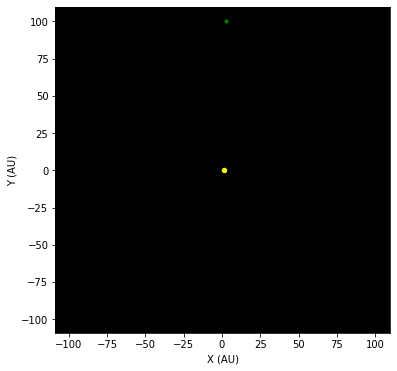

In [25]:
#sets number of frames for simulation 
frames = np.linspace(0,10000-1, 100, dtype = 'int')

#creating an animation of the evolution of a single planet system
fig = plt.figure(figsize = (6,6))
camera = Camera(fig)
ax = plt.axes()
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
ax.set_facecolor("black")

for i in frames:
    plt.scatter(sim_data[0][0,i]/AU, sim_data[1][0,i]/AU, color = 'green', s = 10)
    plt.scatter(sim_data[0][1,i]/AU, sim_data[1][1,i]/AU, color = 'yellow', s = 20)
    #snaps image of plot at each frame
    camera.snap()

#creates the animation and saves it as a gif
animation = camera.animate()
animation.save('SinglePlanetSystem.gif', writer = 'imagemagick')
   

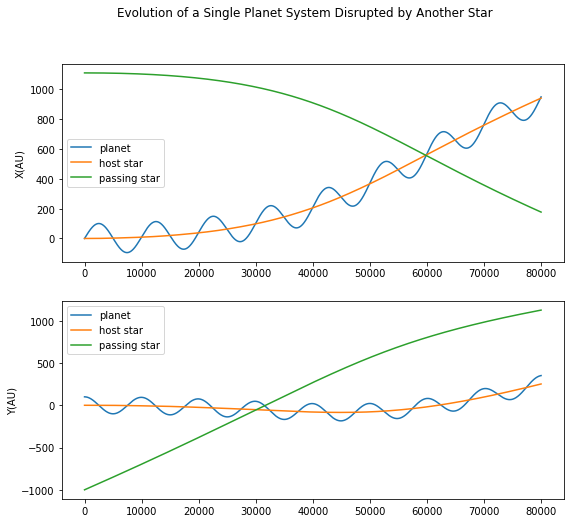

In [44]:
#plotting the positions of a single planet system over time 
#that is subject to an external perturbation due to a passing star

fig, axs = plt.subplots(2)
fig.suptitle('Evolution of a Single Planet System Disrupted by Another Star')
fig.set_figheight(8)
fig.set_figwidth(9)

axs[0].plot(sim_data2[0][0,:]/AU, label = 'planet')
axs[0].plot(sim_data2[0][1,:]/AU, label = 'host star')
axs[0].plot(sim_data2[0][2,:]/AU,label = 'passing star')

axs[1].plot(sim_data2[1][0,:]/AU, label = 'planet')
axs[1].plot(sim_data2[1][1,:]/AU, label = 'host star')
axs[1].plot(sim_data2[1][2,:]/AU, label = 'passing star')

axs[0].legend()
axs[0].set_ylabel("X (AU)")
axs[1].set_ylabel("Y (AU)")
axs[1].legend()

plt.savefig("PlanetSystemDisrupted.pdf")
plt.show()

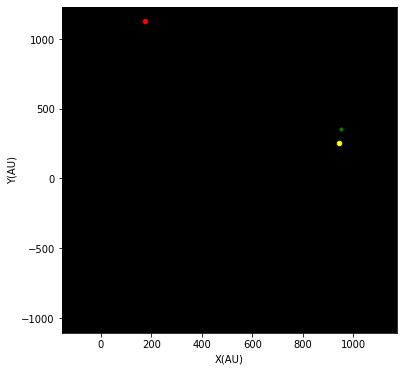

In [50]:
#sets number of frames for simulation 
frames = np.linspace(0,80000-1, 100, dtype = 'int')

#creating an animation of the evolution of a single planet system disrupted by Another Star
fig = plt.figure(figsize = (6,6))
camera = Camera(fig)
ax = plt.axes()
plt.xlabel('X(AU)')
plt.ylabel('Y(AU)')
ax.set_facecolor("black")

for i in frames:
    plt.scatter(sim_data2[0][0,i]/AU, sim_data2[1][0,i]/AU, color = 'green', s = 10)
    plt.scatter(sim_data2[0][1,i]/AU, sim_data2[1][1,i]/AU, color = 'yellow', s = 20)
    plt.scatter(sim_data2[0][2,i]/AU, sim_data2[1][2,i]/AU, s = 20, color = 'red')
    #snaps image of plot at each frame
    camera.snap()

#creates the animation and saves it as a gif
animation = camera.animate()
animation.save('PlanetSystemDisrupted.gif', writer = 'imagemagick')